# Prepare for training I-10 Broadway Curve

### Training input
- features per TMC segment per time interval, including event counts for each type, and segment length

### Training output
- INRIX segment-wise travel time

In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# save I-10 broadway data
data_path = Path('../database/i10-broadway')
data_path.mkdir(parents=True, exist_ok=True)

df_events = pd.read_parquet(data_path / 'events.parquet')
df_inrix = pd.read_parquet(data_path / 'inrix.parquet')
df_tmc = pd.read_parquet(data_path / 'tmc.parquet')

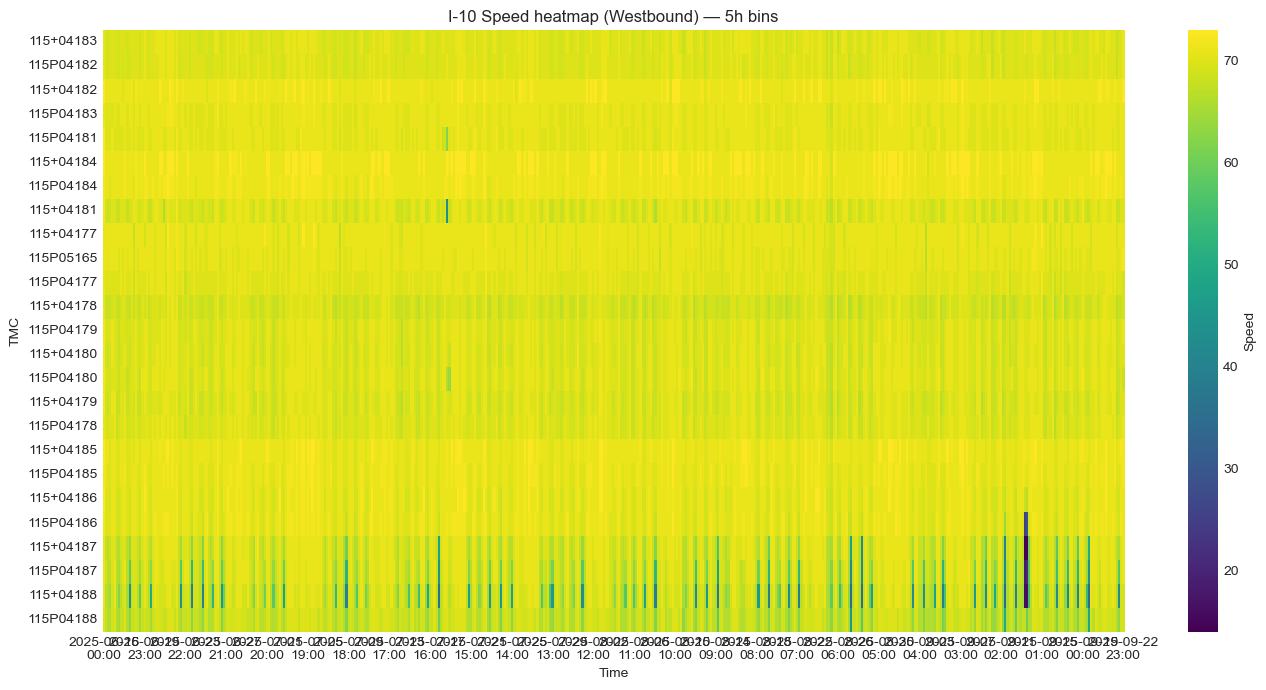

In [4]:
# Visualize travel time in df_inrix
# filter data by eastbound/westbound
# aggregate travel time to 1hr intervals
# plot travel time over time in 2d heatmap - x=time, y=tmc (optionally scaled by segment length)


def plot_travel_time_heatmap(
    df_inrix,
    df_tmc,
    direction='E',
    metric='travel_time',      # 'travel_time' or 'speed'
    interval='1hr',            # '1hr' or '5min' (or pandas offsets like '1H','5T')
    cmap='viridis',
    vmin=None, vmax=None,
    agg='median',
    scale_by_length=False
):
    # Validate required columns (do not modify inputs)
    for col in ['tmc_code', 'measurement_tstamp']:
        if col not in df_inrix.columns:
            raise ValueError(f"df_inrix missing required column: {col}")
    # Metric -> column mapping
    metric = str(metric).lower()
    metric_map = {
        'travel_time': ('travel_time_seconds', 'Travel time (seconds)'),
        'speed': ('speed', 'Speed')
    }
    if metric not in metric_map:
        raise ValueError("metric must be 'travel_time' or 'speed'")
    value_col, cbar_label = metric_map[metric]
    if value_col not in df_inrix.columns:
        raise ValueError(f"df_inrix missing required column for metric: {value_col}")

    for col in ['tmc', 'miles', 'direction']:
        if col not in df_tmc.columns:
            raise ValueError(f"df_tmc missing required column: {col}")

    # Normalize inputs
    # freq = _normalize_interval(interval)
    freq = interval
    def _normalize_dir(x: str):
        if pd.isna(x):
            return None
        s = str(x).upper()
        if 'EAST' in s:
            return 'E'
        if 'WEST' in s:
            return 'W'
        return None


    # Allowed TMCs for this direction (no modification to df_tmc)
    dir_series = df_tmc['direction'].map(_normalize_dir)
    allowed_tmc = df_tmc.loc[dir_series == direction, 'tmc']
    # Filter df_inrix rows by allowed TMCs and valid timestamps/values (no modification to df_inrix)
    base_mask = (
        df_inrix['tmc_code'].isin(allowed_tmc) &
        df_inrix['tmc_code'].notna() &
        df_inrix['measurement_tstamp'].notna()
    )
    s_ts = pd.to_datetime(df_inrix.loc[base_mask, 'measurement_tstamp'], errors='coerce', utc=True)
    s_val = df_inrix.loc[base_mask, value_col]
    s_tmc = df_inrix.loc[base_mask, 'tmc_code']
    valid = s_ts.notna() & s_val.notna()
    if not valid.any():
        raise ValueError("No valid rows after filtering by direction and timestamp/value availability.")

    # Build a minimal temporary frame for aggregation (small and transient)
    tmp = pd.DataFrame({
        'time_bin': s_ts[valid].dt.floor(freq),
        'tmc_code': s_tmc[valid].values,
        value_col: s_val[valid].values
    })

    # Aggregate
    agg_func = 'median' if agg == 'median' else ('mean' if agg == 'mean' else agg)
    pivot = tmp.groupby(['time_bin', 'tmc_code'])[value_col].agg(agg_func).unstack('tmc_code')
    if pivot.empty:
        raise ValueError("No data after filtering/aggregation. Check direction and date ranges.")

    # Order TMCs by longitude (no merge into df_inrix)
    order_meta = (
        df_tmc.loc[df_tmc['tmc'].isin(pivot.columns), ['tmc', 'start_longitude']]
        .dropna()
        .drop_duplicates()
    )
    if not order_meta.empty:
        ascending = True if direction == 'E' else False
        ordered_tmc = order_meta.sort_values('start_longitude', ascending=ascending)['tmc'].tolist()
        leftover = [c for c in pivot.columns if c not in ordered_tmc]
        ordered_tmc += sorted(leftover)
    else:
        ordered_tmc = sorted(pivot.columns.tolist())
    pivot = pivot.reindex(columns=ordered_tmc)

    # Regularize time index on the result only
    start, end = pivot.index.min(), pivot.index.max()
    full_times = pd.date_range(start, end, freq=freq)
    pivot = pivot.reindex(index=full_times)

    # Seaborn heatmap (equal-height cells)
    if not scale_by_length:
        fig, ax = plt.subplots(figsize=(14, 7))
        sns.heatmap(
            pivot.T, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
            cbar_kws={'label': cbar_label},
            mask=pivot.T.isna()
        )
        title_metric = "Travel time" if metric == 'travel_time' else "Speed"
        ax.set_title(f"I-10 {title_metric} heatmap ({'Eastbound' if direction=='E' else 'Westbound'}) — {freq} bins")
        ax.set_xlabel("Time")
        ax.set_ylabel("TMC")
        n_times = len(pivot.index)
        step = max(1, n_times // 24)
        xticks = np.arange(0, n_times, step)
        ax.set_xticks(xticks + 0.5)
        ax.set_xticklabels([t.strftime('%Y-%m-%d\n%H:%M') for t in pivot.index[::step]], rotation=0)
        plt.tight_layout()
        plt.show()
        return

    # Length-scaled cells using miles (only from df_tmc)
    lengths = (
        df_tmc.loc[df_tmc['tmc'].isin(ordered_tmc)]
              .drop_duplicates(subset=['tmc'])
              .set_index('tmc')
              .reindex(ordered_tmc)['miles']
              .astype(float)
              .fillna(0.01)
    )
    y_edges = np.r_[0.0, np.cumsum(lengths.values)]
    x_edges_dt = np.r_[full_times.values, (full_times[-1] + pd.to_timedelta(freq)).to_datetime64()]
    x_edges = mdates.date2num(pd.to_datetime(x_edges_dt))
    Z = pivot.T.values

    fig, ax = plt.subplots(figsize=(14, 7))
    X, Y = np.meshgrid(x_edges, y_edges)
    pcm = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label=cbar_label)
    title_metric = "Travel time" if metric == 'travel_time' else "Speed"
    ax.set_title(f"I-10 {title_metric} heatmap (length-scaled, {'Eastbound' if direction =='E' else 'Westbound'}) — {freq} bins")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulative miles")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.tight_layout()
    plt.show()


# Examples:
plot_travel_time_heatmap(df_inrix, df_tmc, direction='W', metric='speed', interval='5h', scale_by_length=False)
# plot_travel_time_heatmap(df_inrix, df_tmc, direction='W', metric='travel_time', interval='5h', scale_by_length=True)

In [3]:
# 5 custom impact categories with renamed short labels
event_mapping = {
    # 1. Major Lane-Blocking
    "crashRlane": "cat_major",
    "crashLlane": "cat_major",
    "crashHOV": "cat_major",
    "C34Rlane": "cat_major",
    "C34leftLanes": "cat_major",
    "C34HOVlane": "cat_major",
    "Freewayclosed": "cat_major",
    "RoadClosedDueToCrash": "cat_major",
    "AccidentIncident": "cat_major",
    "accident": "cat_major",
    "CrashMedian": "cat_major",
    "crashBIntersection": "cat_major",

    # 2. Shoulder/Ramp Incidents (Minor)
    "C34Rshoulder": "cat_minor",
    "C34Lshoulder": "cat_minor",
    "Crash on right shoulder": "cat_minor",
    "CrashLshoulder": "cat_minor",
    "DebrisRshoulder": "cat_minor",
    "debrisLshoulder": "cat_minor",
    "vehicleOnFire": "cat_minor",
    "pedestrianOnRoadway": "cat_minor",
    "animalOnRoadway": "cat_minor",
    "C34exit": "cat_minor",
    "TC34EXB": "cat_minor",
    "C34onramp": "cat_minor",
    "crashBOnramp": "cat_minor",
    "crashExit": "cat_minor",
    "crashBExit": "cat_minor",
    "crashOnramp": "cat_minor",
    "TC34ONB": "cat_minor",

    # 3. Roadwork/Planned Closures
    "leftlanes": "cat_closure",
    "rightlanes": "cat_closure",
    "LeftLane": "cat_closure",
    "rightlane": "cat_closure",
    "shoulderclosed": "cat_closure",
    "exitrestricted": "cat_closure",
    "exitclosed": "cat_closure",
    "hovrampclosed": "cat_closure",
    "ramp2westclosed": "cat_closure",
    "ramp2eastclosed": "cat_closure",
    "patching": "cat_closure",

    # 4. Road Obstructions / Debris
    "debrisLlane": "cat_obstruction",
    "debrisRlane": "cat_obstruction",
    "debrisinroad": "cat_obstruction",
    "debrisClane": "cat_obstruction",
    "Potholes": "cat_obstruction",
    "DeadAnimalRoad": "cat_obstruction",
    "Graffiti": "cat_obstruction",
    "guardrail": "cat_obstruction",
    "fencedamage": "cat_obstruction",

    # 5. Infrastructure / Miscellaneous
    "signaltiming": "cat_misc",
    "SignalIssue": "cat_misc",
    "SignalRedbulb": "cat_misc",
    "signdamaged": "cat_misc",
    "ITS Equipment Damage": "cat_misc",
    "TDMG": "cat_misc",
    "T1018SR": "cat_misc",
    "TDMGLEAK": "cat_misc",
    "TDEBRISRM": "cat_misc",
    "TDEBRISLM": "cat_misc",
    "TDEBRISCM": "cat_misc",
    "TDEBRISONB": "cat_misc",
    "TC34I": "cat_misc",
}

# apply to your dataframe
df_events["cat_event_type"] = df_events["EventSubType"].map(event_mapping).fillna("cat_misc")

In [5]:
event_mapping = {
    # 1. Major Lane-Blocking
    "crashRlane": "cat_unplanned",
    "crashLlane": "cat_unplanned",
    "crashHOV": "cat_unplanned",
    "C34Rlane": "cat_unplanned",
    "C34leftLanes": "cat_unplanned",
    "C34HOVlane": "cat_unplanned",
    "Freewayclosed": "cat_unplanned",
    "RoadClosedDueToCrash": "cat_unplanned",
    "AccidentIncident": "cat_unplanned",
    "accident": "cat_unplanned",
    "CrashMedian": "cat_unplanned",
    "crashBIntersection": "cat_unplanned",

    # 2. Shoulder/Ramp Incidents (Minor)
    "C34Rshoulder": "cat_unplanned",
    "C34Lshoulder": "cat_unplanned",
    "Crash on right shoulder": "cat_unplanned",
    "CrashLshoulder": "cat_unplanned",
    "DebrisRshoulder": "cat_unplanned",
    "debrisLshoulder": "cat_unplanned",
    "vehicleOnFire": "cat_unplanned",
    "pedestrianOnRoadway": "cat_unplanned",
    "animalOnRoadway": "cat_unplanned",
    "C34exit": "cat_unplanned",
    "TC34EXB": "cat_unplanned",
    "C34onramp": "cat_unplanned",
    "crashBOnramp": "cat_unplanned",
    "crashExit": "cat_unplanned",
    "crashBExit": "cat_unplanned",
    "crashOnramp": "cat_unplanned",
    "TC34ONB": "cat_unplanned",

    # 3. Roadwork/Planned Closures
    "leftlanes": "cat_planned",
    "rightlanes": "cat_planned",
    "LeftLane": "cat_planned",
    "rightlane": "cat_planned",
    "shoulderclosed": "cat_planned",
    "exitrestricted": "cat_planned",
    "exitclosed": "cat_planned",
    "hovrampclosed": "cat_planned",
    "ramp2westclosed": "cat_planned",
    "ramp2eastclosed": "cat_planned",
    "patching": "cat_planned",

    # 4. Road unplanneds / Debris
    "debrisLlane": "cat_unplanned",
    "debrisRlane": "cat_unplanned",
    "debrisinroad": "cat_unplanned",
    "debrisClane": "cat_unplanned",
    "Potholes": "cat_unplanned",
    "DeadAnimalRoad": "cat_unplanned",
    "Graffiti": "cat_unplanned",
    "guardrail": "cat_unplanned",
    "fencedamage": "cat_unplanned",

    # 5. Infrastructure / Miscellaneous
    "signaltiming": "cat_unplanned",
    "SignalIssue": "cat_unplanned",
    "SignalRedbulb": "cat_unplanned",
    "signdamaged": "cat_unplanned",
    "ITS Equipment Damage": "cat_unplanned",
    "TDMG": "cat_unplanned",
    "T1018SR": "cat_unplanned",
    "TDMGLEAK": "cat_unplanned",
    "TDEBRISRM": "cat_unplanned",
    "TDEBRISLM": "cat_unplanned",
    "TDEBRISCM": "cat_unplanned",
    "TDEBRISONB": "cat_unplanned",
    "TC34I": "cat_unplanned",
}

# apply to your dataframe
df_events["cat_event_type"] = df_events["EventSubType"].map(event_mapping).fillna("cat_unplanned")

In [6]:
# Compute duration (minutes)
def compute_duration(row):
    if row["EventType"] in ['closures', 'roadwork']:
        if pd.notnull(row["StartDate"]) and pd.notnull(row["PlannedEndDate"]):
            return (row["PlannedEndDate"] - row["StartDate"]) / 60.0
    elif row["EventType"] == 'accidentsAndIncidents':
        if pd.notnull(row["Reported"]) and pd.notnull(row["LastUpdated"]):
            return (row["LastUpdated"] - row["Reported"]) / 60.0
    return None
df_events["duration"] = df_events.apply(compute_duration, axis=1)

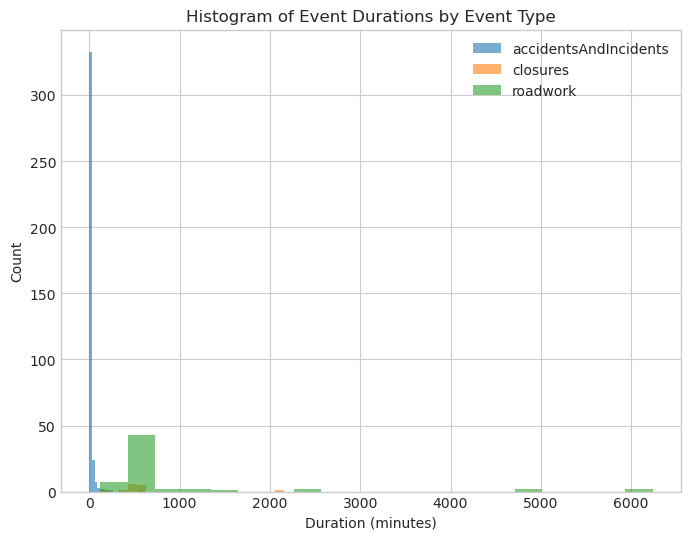

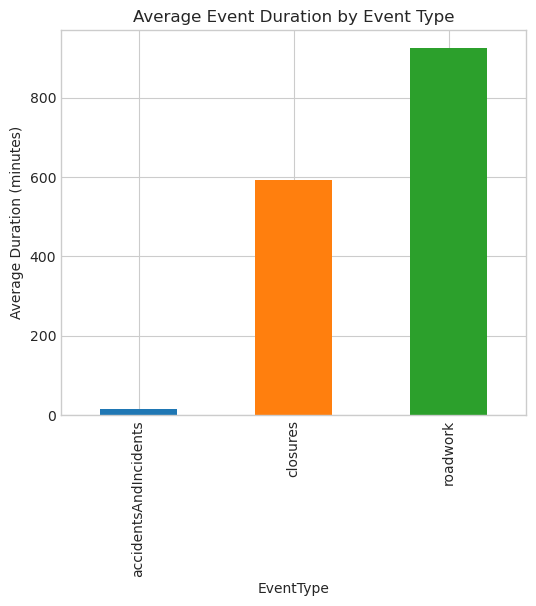

In [17]:

# -------------------
# Histogram of durations by event type
# -------------------
plt.figure(figsize=(8,6))
for etype, subset in df_events.groupby("EventType"):
    plt.hist(
        subset["duration"].dropna(),
        bins=20,
        alpha=0.6,
        label=etype
    )

plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.title("Histogram of Event Durations by Event Type")
plt.legend()
plt.show()

# -------------------
# Bar plot of average durations by event type
# -------------------
avg_durations = df_events.groupby("EventType")["duration"].mean()

plt.figure(figsize=(6,5))
avg_durations.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.ylabel("Average Duration (minutes)")
plt.title("Average Event Duration by Event Type")
plt.show()

In [7]:
# Prepare for training data X from df_events and df_inrix
# drop columns from df_inrix:'reference_speed','confidence_score', 'cvalue', 'Inrix 2013','Inrix 2019'
# aggregate df_inrix speed and travel time to [5-minute] intervals for each tmc_code, make the interval a parameter, keep the first from other columns

interval = '1h'  # parameterizable

# Drop optional columns if present
cols_to_drop = ['confidence_score', 'cvalue', 'Inrix 2013', 'Inrix 2019']
df_inrix = df_inrix.drop(columns=[c for c in cols_to_drop if c in df_inrix.columns], errors='ignore')

# Require time and TMC columns
time_col = 'measurement_tstamp'
group_col = 'tmc_code'
if time_col not in df_inrix.columns or group_col not in df_inrix.columns:
    raise ValueError(f"df_inrix must contain '{time_col}' and '{group_col}'")

# Build aggregation map
value_cols = [c for c in ['speed', 'travel_time_seconds','reference_speed'] if c in df_inrix.columns]
agg_map = {c: 'mean' for c in value_cols}
other_cols = [c for c in df_inrix.columns if c not in set(value_cols + [time_col, group_col])]
for c in other_cols:
    agg_map[c] = 'first'

# Compute time bins and aggregate per TMC and bin
tmp = df_inrix.copy()
tmp['time_bin'] = pd.to_datetime(tmp[time_col], unit='s', errors='coerce', utc=True).dt.floor(interval)
tmp = tmp.dropna(subset=['time_bin', group_col])

X = (
    tmp
    .groupby([group_col, 'time_bin'], as_index=False)
    .agg(agg_map)
    .sort_values([group_col, 'time_bin'])
    .set_index([group_col, 'time_bin'])
)


In [6]:
X

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 00:00:00+00:00  70.133333             7.598167   
          2025-06-16 01:00:00+00:00  69.583333             7.665000   
          2025-06-16 02:00:00+00:00  67.300000             7.950667   
          2025-06-16 03:00:00+00:00  71.933333             7.411000   
          2025-06-16 04:00:00+00:00  71.816667             7.422000   
...                                        ...                  ...   
115P05165 2025-09-22 20:00:00+00:00  70.100000            14.627333   
          2025-09-22 21:00:00+00:00  71.450000            14.355000   
          2025-09-22 22:00:00+00:00  71.666667            14.312833   
          2025-09-22 23:00:00+00:00  70.633333            14.546167   
          2025-09-23 00:00:00+00:00  60.000000            17.080000   

                                     reference_speed  
tmc_code  time_bin                                    
115+04177 2025-06-16 00:00:00+00:00             70.0  
          2025-06-16 01:00:00+00:00             70.0  
          2025-06-16 02:00:00+00:00             70.0  
          2025-06-16 03:00:00+00:00             70.0  
          2025-06-16 04:00:00+00:00             70.0  
...                                              ...  
115P05165 2025-09-22 20:00:00+00:00             70.0  
          2025-09-22 21:00:00+00:00             70.0  
          2025-09-22 22:00:00+00:00             70.0  
          2025-09-22 23:00:00+00:00             70.0  
          2025-09-23 00:00:00+00:00             70.0  

[118841 rows x 3 columns]

In [8]:
# ----------------------------
# Add event-overlap features
# match tmc_code in df_inrix with near_tmc from df_events, if the event has any time overlap with this time interval.
# time overlap is defined similar to the start and end date used to calculate duration
# ----------------------------

# Normalize event type and parse timestamps (UTC)
etype = df_events['EventType'].astype(str).str.strip().str.lower()
s_startdate = pd.to_datetime(df_events.get('StartDate'), unit='s', errors='coerce', utc=True)
s_plannedend = pd.to_datetime(df_events.get('PlannedEndDate'), unit='s', errors='coerce', utc=True)
s_reported   = pd.to_datetime(df_events.get('Reported'), unit='s', errors='coerce', utc=True)
s_lastupdate = pd.to_datetime(df_events.get('LastUpdated'), unit='s', errors='coerce', utc=True)

# Determine event windows per rules
is_plan = etype.isin(['closures', 'roadwork'])
is_inc  = etype.eq('accidentsandincidents')

event_start = pd.Series(pd.NaT, index=df_events.index, dtype='datetime64[s, UTC]')
event_end   = pd.Series(pd.NaT, index=df_events.index, dtype='datetime64[s, UTC]')

event_start[is_plan] = s_startdate[is_plan]
event_end[is_plan]   = s_plannedend[is_plan]
event_start[is_inc]  = s_reported[is_inc]
event_end[is_inc]    = s_lastupdate[is_inc]

# If end is missing, fall back to start (zero-length window)
event_end = event_end.fillna(event_start)

# Keep needed event fields and normalize near_tmc to string for matching
# evt_cat_levels = ['cat_major','cat_minor','cat_closure','cat_obstruction','cat_misc']
evt_cat_levels = ['cat_unplanned','cat_planned']
events_proc = pd.DataFrame({
    'near_tmc_str': df_events['near_tmc'].astype(str),
    'event_start': event_start,
    'event_end': event_end,
    'cat': df_events.get('cat_event_type', 'cat_misc').astype(str),
    # 'duration': pd.to_numeric(df_events.get('duration'), errors='coerce')
}).dropna(subset=['near_tmc_str', 'event_start', 'event_end'])
events_proc['cat'] = events_proc['cat'].where(events_proc['cat'].isin(evt_cat_levels), 'cat_unplanned')
# events_proc['duration'] = events_proc['duration'].fillna(0.0).astype(float)

In [9]:
# Build event features per (tmc_code, time_bin)
evt_cols = ['evt_duration'] + [f'evt_{c}' for c in evt_cat_levels]
evt_parts = []

tmcs = X.index.get_level_values(group_col).unique().sort_values()
for tmc in tmcs:
    # bins for this TMC
    b_times = X.loc[tmc].index if (tmc in X.index.get_level_values(0)) else pd.Index([], dtype='datetime64[s, UTC]')
    if len(b_times) == 0:
        continue
    b_start = pd.DatetimeIndex(b_times)
    b_end = b_start + pd.to_timedelta(interval)

    # events for this near_tmc
    edf = events_proc[events_proc['near_tmc_str'] == str(tmc)]
    if edf.empty:
        feat = pd.DataFrame(0, index=b_start, columns=evt_cols)
    else:
        e_start = edf['event_start'].to_numpy()
        e_end   = edf['event_end'].to_numpy()
        cat_vals = edf['cat'].to_numpy()

        # overlap: (bin_start < event_end) & (bin_end > event_start)
        bs = b_start.to_numpy()[:, None]
        be = b_end.to_numpy()[:, None]
        overlap = (bs < e_end[None, :]) & (be > e_start[None, :])

        # per-category counts for each bin
        data = {}
        for c in evt_cat_levels:
            mask_c = (cat_vals[None, :] == c)
            data[f'evt_{c}'] = (overlap & mask_c).sum(axis=1).astype(int)

        feat = pd.DataFrame(data, index=b_start)

    feat.index.name = 'time_bin'
    feat[group_col] = tmc
    feat = feat.reset_index().set_index([group_col, 'time_bin']).sort_index()
    evt_parts.append(feat)

if evt_parts:
    evt_df = pd.concat(evt_parts).sort_index()
else:
    # No events matched any TMC; create zeros for existing index
    print("No events matched any TMC; event features will be zero.")
    evt_df = pd.DataFrame(0, index=X.index, columns=evt_cols)

# Join event features to X_df
X = X.join(evt_df, how='right')
# ----------------------------

# Fold into 3D tensor: [tmc_code, time_bin, feature]
tmcs = X.index.get_level_values(group_col).unique().sort_values()
times = X.index.get_level_values('time_bin').unique().sort_values()
full_idx = pd.MultiIndex.from_product([tmcs, times], names=[group_col, 'time_bin'])
X_full = X.reindex(full_idx)

# Fill event features with 0; leave measurements as NaN if missing
X_full[evt_cols] = X_full[evt_cols].fillna(0)

# Ensure miles present for all (tmc,time)
miles_map = df_tmc.drop_duplicates('tmc').set_index('tmc')['miles'].astype(float)
X_full['miles'] = X_full.index.get_level_values(group_col).map(miles_map)

# NEW: Map tmc_tags dict into per-TMC indicator columns and add to X_full
tmc_base = df_tmc.drop_duplicates('tmc').set_index('tmc')
tag_cols = []
if 'tmc_tags' in tmc_base.columns:
    # Expand dicts to columns while preserving TMC index
    tags_norm = (
        tmc_base['tmc_tags']
        .apply(lambda v: v if isinstance(v, dict) else {})  # ensure dict
        .apply(pd.Series)
        .fillna(0)
    )
    # Ensure numeric 0/1
    tags_norm = tags_norm.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

    tag_cols = tags_norm.columns.tolist()

    # Map each tag column to X_full by tmc_code (constant across time)
    tmc_idx = X_full.index.get_level_values(group_col)
    for col in tag_cols:
        mapping = tags_norm[col].to_dict()  # keys are TMC codes
        X_full[col] = tmc_idx.map(mapping).fillna(0).astype(int)
else:
    print("Warning: 'tmc_tags' not found in df_tmc; no TMC tag features added.")

# Final feature list (measurements + event features + miles + tmc tag features)
features = value_cols + evt_cols + ['miles'] + tag_cols

X = X_full[features].to_numpy().reshape(len(tmcs), len(times), len(features))

# Keep references to indices and feature names for downstream use
X_tmc_index = tmcs.tolist()
X_time_index = pd.DatetimeIndex(times)  # UTC
X_features = features

print("X shape:", X.shape)
print("#TMC:", len(X_tmc_index), "#Time bins:", len(X_time_index), "Features:", X_features)


X shape: (50, 2377, 10)
#TMC: 50 #Time bins: 2377 Features: ['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration', 'evt_cat_unplanned', 'evt_cat_planned', 'miles', 'curve', 'offramp', 'onramp']


In [10]:
X_full[11800:11805]

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04181 2025-09-19 12:00:00+00:00  67.000000            68.362667   
          2025-09-19 13:00:00+00:00  67.366667            67.958333   
          2025-09-19 14:00:00+00:00  67.000000            68.322333   
          2025-09-19 15:00:00+00:00  67.166667            68.161333   
          2025-09-19 16:00:00+00:00  66.800000            68.527000   

                                     reference_speed  evt_duration  \
tmc_code  time_bin                                                   
115+04181 2025-09-19 12:00:00+00:00             68.0           0.0   
          2025-09-19 13:00:00+00:00             68.0           0.0   
          2025-09-19 14:00:00+00:00             68.0           0.0   
          2025-09-19 15:00:00+00:00             68.0           0.0   
          2025-09-19 16:00:00+00:00             68.0           0.0   

                                     evt_cat_unplanned  evt_cat_planned  \
tmc_code  time_bin                                                        
115+04181 2025-09-19 12:00:00+00:00                0.0              0.0   
          2025-09-19 13:00:00+00:00                0.0              0.0   
          2025-09-19 14:00:00+00:00                0.0              0.0   
          2025-09-19 15:00:00+00:00                0.0              0.0   
          2025-09-19 16:00:00+00:00                0.0              0.0   

                                        miles  curve  offramp  onramp  
tmc_code  time_bin                                                     
115+04181 2025-09-19 12:00:00+00:00  1.270297      0        1       0  
          2025-09-19 13:00:00+00:00  1.270297      0        1       0  
          2025-09-19 14:00:00+00:00  1.270297      0        1       0  
          2025-09-19 15:00:00+00:00  1.270297      0        1       0  
          2025-09-19 16:00:00+00:00  1.270297      0        1       0

In [11]:
X_full[features].sum()

speed                  8.312749e+06
travel_time_seconds    3.042298e+06
reference_speed        7.919570e+06
evt_duration           0.000000e+00
evt_cat_unplanned      4.080000e+02
evt_cat_planned        5.300000e+02
miles                  5.873813e+04
curve                  3.803200e+04
offramp                5.942500e+04
onramp                 6.417900e+04
dtype: float64

In [12]:
evt_cols

['evt_duration', 'evt_cat_unplanned', 'evt_cat_planned']

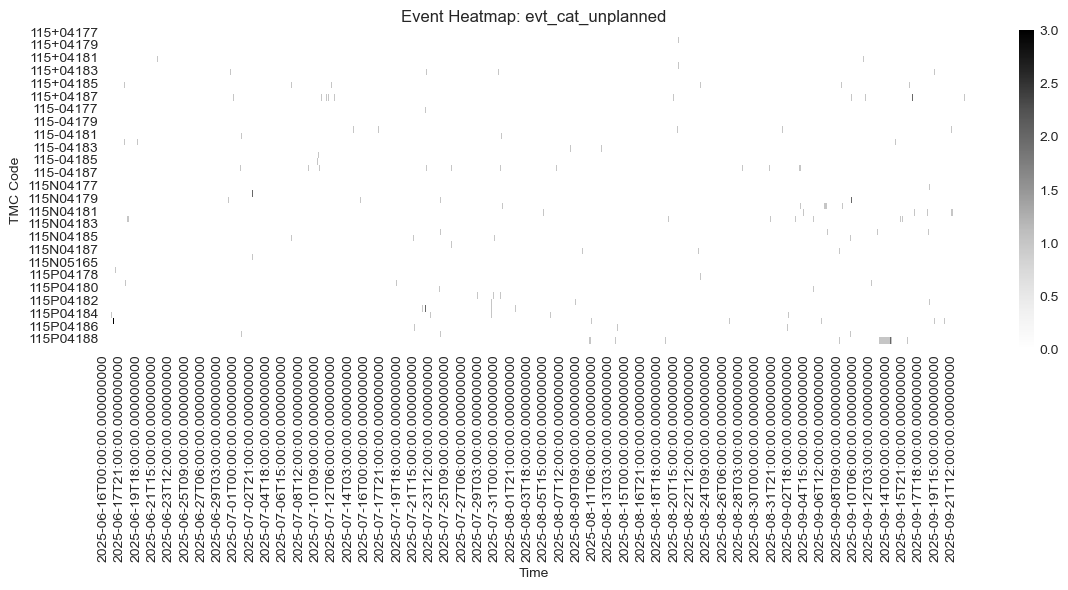

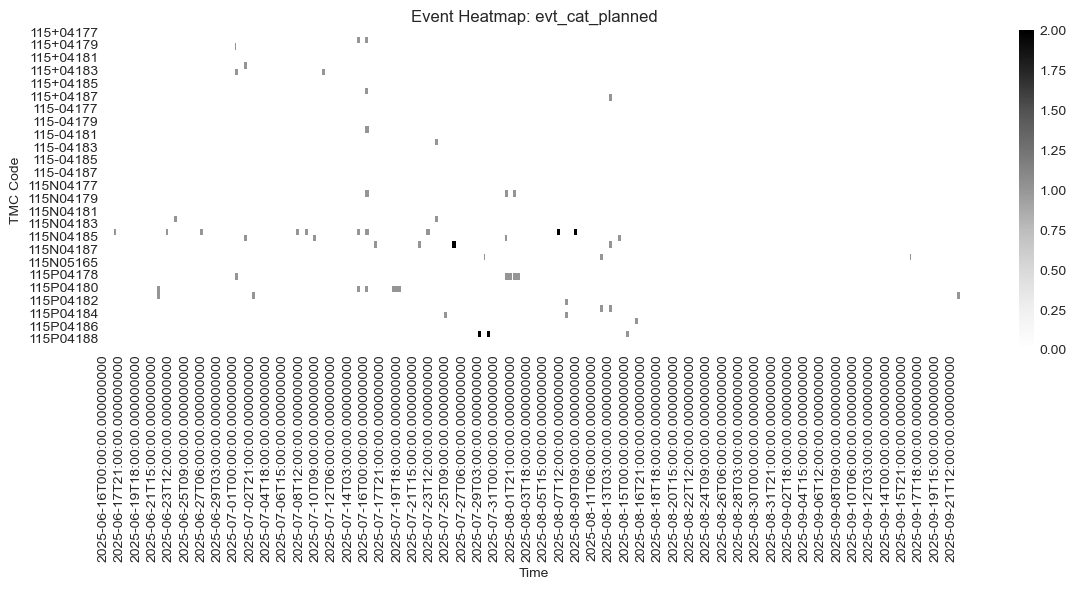

In [13]:
# plotting to see the event features over time and TMCs
# Example: aggregate by hour (optional)
X_hourly = (
    X_full
    .groupby([pd.Grouper(level='tmc_code'),
              pd.Grouper(level='time_bin', freq='1h')])
    .sum()
)
cols = ['evt_cat_unplanned', 'evt_cat_planned']
X_sel = X_hourly[cols]
for col in cols:
    data = X_sel[col].unstack(level='tmc_code').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.T, cmap='Greys')
    plt.title(f"Event Heatmap: {col}")
    plt.xlabel("Time")
    plt.ylabel("TMC Code")
    plt.tight_layout()
    plt.show()

In [14]:
# save data in .npz
# interpolate missing values in X_tensor if needed
def interpolate_missing(df, method='linear', limit_direction='both'):
    """
    Interpolate missing feature values per TMC segment.
    Works safely on MultiIndex ['tmc_code', 'time_bin'].
    """
    df = df.copy()
    interpolated = (
        df.groupby(level='tmc_code')
          .apply(lambda g: g.sort_index(level='time_bin')
                           .interpolate(method=method, limit_direction=limit_direction))
          .droplevel(0)  # remove extra grouping index
    )
    return interpolated

X_full = interpolate_missing(X_full)
for c in X_full.columns:
    print(c, np.isnan(X_full[c]).sum(), "NaNs")
    


speed 0 NaNs
travel_time_seconds 0 NaNs
reference_speed 0 NaNs
evt_duration 0 NaNs
evt_cat_unplanned 0 NaNs
evt_cat_planned 0 NaNs
miles 0 NaNs
curve 0 NaNs
offramp 0 NaNs
onramp 0 NaNs


In [15]:
# Add time-based features and derived features
# Extract time level
time_index = X_full.index.get_level_values('time_bin')

# Add hour and day-of-week features directly to X_full
events_col = ['evt_cat_unplanned', 'evt_cat_planned']
X_full = X_full.assign(
    hour_sin = np.sin(2 * np.pi * time_index.hour / 24),
    hour_cos = np.cos(2 * np.pi * time_index.hour / 24),
    dow_sin  = np.sin(2 * np.pi * time_index.dayofweek / 7),
    dow_cos  = np.cos(2 * np.pi * time_index.dayofweek / 7),
    hour_of_week = time_index.dayofweek * 24 + time_index.hour,
    hour_of_week_sin = np.sin(2 * np.pi * (time_index.dayofweek * 24 + time_index.hour) / (7 * 24)),
    hour_of_week_cos = np.cos(2 * np.pi * (time_index.dayofweek * 24 + time_index.hour) / (7 * 24)),
    is_weekend = (time_index.dayofweek >= 5).astype(int),
    evt_total = X_full[events_col].sum(axis=1),
    speed_ratio = X_full['speed'] / X_full['reference_speed']
)

In [16]:
# Function to add lag features
def add_lag_features(df, target_col='travel_time_seconds', lags=[1, 2, 3]):
    # df = df.copy()
    for lag in lags:
        df[f'lag{lag}'] = (
            df.groupby(level='tmc_code')[target_col]
              .shift(lag)
        )
    return df

X_full = add_lag_features(X_full, target_col='travel_time_seconds', lags=[1, 2, 3])
X_full = X_full.dropna(subset=['lag1', 'lag2', 'lag3'])

In [17]:
X_full['tt_per_mile'] = X_full['travel_time_seconds'] / X_full['miles']
X_full['lag1_tt_per_mile'] = X_full['lag1'] / X_full['miles']
X_full['lag2_tt_per_mile'] = X_full['lag2'] / X_full['miles']
X_full['lag3_tt_per_mile'] = X_full['lag3'] / X_full['miles']

In [18]:
X_full.head()

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 03:00:00+00:00  71.933333               7.4110   
          2025-06-16 04:00:00+00:00  71.816667               7.4220   
          2025-06-16 05:00:00+00:00  71.066667               7.4975   
          2025-06-16 06:00:00+00:00  71.550000               7.4455   
          2025-06-16 07:00:00+00:00  70.516667               7.5555   

                                     reference_speed  evt_duration  \
tmc_code  time_bin                                                   
115+04177 2025-06-16 03:00:00+00:00             70.0           0.0   
          2025-06-16 04:00:00+00:00             70.0           0.0   
          2025-06-16 05:00:00+00:00             70.0           0.0   
          2025-06-16 06:00:00+00:00             70.0           0.0   
          2025-06-16 07:00:00+00:00             70.0           0.0   

                                     evt_cat_unplanned  evt_cat_planned  \
tmc_code  time_bin                                                        
115+04177 2025-06-16 03:00:00+00:00                0.0              0.0   
          2025-06-16 04:00:00+00:00                0.0              0.0   
          2025-06-16 05:00:00+00:00                0.0              0.0   
          2025-06-16 06:00:00+00:00                0.0              0.0   
          2025-06-16 07:00:00+00:00                0.0              0.0   

                                        miles  curve  offramp  onramp  \
tmc_code  time_bin                                                      
115+04177 2025-06-16 03:00:00+00:00  0.147902      0        0       0   
          2025-06-16 04:00:00+00:00  0.147902      0        0       0   
          2025-06-16 05:00:00+00:00  0.147902      0        0       0   
          2025-06-16 06:00:00+00:00  0.147902      0        0       0   
          2025-06-16 07:00:00+00:00  0.147902      0        0       0   

                                     hour_sin      hour_cos  dow_sin  dow_cos  \
tmc_code  time_bin                                                              
115+04177 2025-06-16 03:00:00+00:00  0.707107  7.071068e-01      0.0      1.0   
          2025-06-16 04:00:00+00:00  0.866025  5.000000e-01      0.0      1.0   
          2025-06-16 05:00:00+00:00  0.965926  2.588190e-01      0.0      1.0   
          2025-06-16 06:00:00+00:00  1.000000  6.123234e-17      0.0      1.0   
          2025-06-16 07:00:00+00:00  0.965926 -2.588190e-01      0.0      1.0   

                                     hour_of_week  hour_of_week_sin  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 03:00:00+00:00             3          0.111964   
          2025-06-16 04:00:00+00:00             4          0.149042   
          2025-06-16 05:00:00+00:00             5          0.185912   
          2025-06-16 06:00:00+00:00             6          0.222521   
          2025-06-16 07:00:00+00:00             7          0.258819   

                                     hour_of_week_cos  is_weekend  evt_total  \
tmc_code  time_bin                                                             
115+04177 2025-06-16 03:00:00+00:00          0.993712           0        0.0   
          2025-06-16 04:00:00+00:00          0.988831           0        0.0   
          2025-06-16 05:00:00+00:00          0.982566           0        0.0   
          2025-06-16 06:00:00+00:00          0.974928           0        0.0   
          2025-06-16 07:00:00+00:00          0.965926           0        0.0   

                                     speed_ratio      lag1      lag2  \
tmc_code  time_bin                                                     
115+04177 2025-06-16 03:00:00+00:00     1.027619  7.950667  7.665000   
          2025-06-16 04:00:00+00:00     1.025952  7.411000  7.950667   
          2025-06-16 05:00:00+00:00     1.015238  7.422000  7.411000   
          2025-06-16 06:00:

In [9]:
# ===== Fold into 3d tensor =====
# (n_tmc, n_time, n_features)

# Get unique levels
tmc_codes = X_full.index.get_level_values("tmc_code").unique()
time_bins = X_full.index.get_level_values("time_bin").unique()
features = X_full.columns

# Convert to 3D tensor
X_tensor = (
    X_full
    .to_numpy()
    .reshape(len(tmc_codes), len(time_bins), len(features))
)

print("Tensor shape:", X_tensor.shape)


Tensor shape: (50, 2386, 10)


In [19]:
# np.savez_compressed(
#     data_path / 'X_tensor_1h.npz',
#     X_tensor=X_tensor
# )
X_full.to_parquet(data_path / 'X_full_1h.parquet')

In [46]:
X_full.columns

Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_unplanned', 'evt_cat_planned', 'miles', 'curve', 'offramp',
       'onramp', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week',
       'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'evt_total',
       'speed_ratio', 'lag1', 'lag2', 'lag3', 'tt_per_mile',
       'lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile'],
      dtype='object')